# Bag-of-Words Application Example : Spam Filtering

One of the most classic applications of bag-of-words technique is spam filtering. We are already very familier with automatic spam filtering features provided by many email services providers. Have you wondered ever what algorithm is running under the hood to keep spam emails from our inbox? Then, you are in the right place. With the following coding example, you will be able to gain a deeper understanding of how bag-of-words algorithm works and how it determines whether an email is a spam or not. Without further ado, Let's get right in.

## The Dataset: "spam.csv"

The dataset that we will be working with is "spam.csv" which is composed of two columns;
   1. v1: Ground truth label (ham or spam, where ham represents legit text messages)
   2. v2: the raw text of email messages

The dataset can be downloaded from Keggle for free via the link below.

https://www.kaggle.com/uciml/sms-spam-collection-dataset

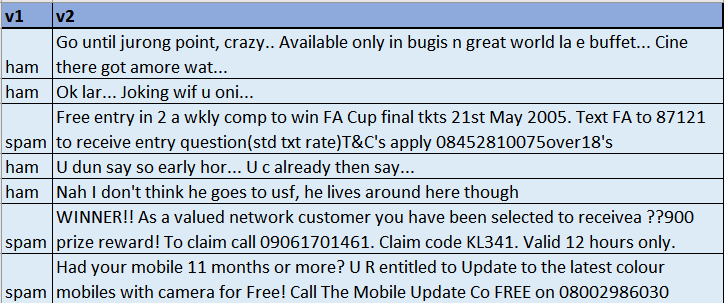

## Data Cleansing and Transformation (as part of ETL)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

# Read the downloaded dataset and load it as a dataframe
spam_df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

# Take the 2 columns we are interested in and give them meaningful names
spam_df = spam_df[['v1', 'v2']]
spam_df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)

# Convert "spam/ham" to binary values (0 or 1)
spam_df['label'] = spam_df['label'].apply(lambda a: True if a=='spam' else False)

# lowercase everything and remove punctuations
# Use str.maketrans(x,y,z) to construct a translate table
# (where z represents a group of chars to be removed from the string)
table = str.maketrans('', '', string.punctuation)
spam_df['text'] = spam_df['text'].apply(lambda t: t.lower().translate(table))

# shuffle records randomly
spam_df = spam_df.sample(frac=1)

The first set of codes is intended to do data preparation (ETL) before we get to the business. A few things to point out in this part of the code;
   1. Because we will be using ML model later on, we need to convert labels into binary values (0 or 1)
   2. For bag-of-words, we only care about the total count of each word regardless of their cases. Therefore, we are turning all the words into lowercase and remove all the punctuations from the text.
   3. Records are shuffled randomly so that spam and non-spam data are evenly divided into training and test sets.

## Exploring Dataset

In [5]:
spam_df

,label,text
3692,False,i was about to do it when i texted i finished ...
5163,False,ok leave no need to ask
2890,False,yeah theres quite a bit left ill swing by tomo...
247,False,kallis wont bat in 2nd innings
4553,False,try to do something dear you read something fo...
...,...,...
2721,False,im working technical support voice process
3953,False,i probably wont eat at all today i think im go...
1994,False,have you been practising your curtsey
4725,False,jason says its cool if we pick some up from hi...


In [6]:
# Texts with "spam" labels
for t in spam_df[spam_df['label'] == True].iloc[:5]['text']:
    print(t)
    print('---------------------------------------------------')

urgent please call 09066612661 from your landline your complimentary 4 lux costa del sol holiday or å£1000 cash await collection ppm 150 sae tcs james 28 eh74rr
---------------------------------------------------
big brother alert the computer has selected u for 10k cash or 150 voucher call 09064018838 ntt po box cro1327 18 bt landline cost 150ppm mobiles vary
---------------------------------------------------
call 09095350301 and send our girls into erotic ecstacy just 60pmin to stop texts call 08712460324 nat rate
---------------------------------------------------
guess who am ithis is the first time i created a web page wwwasjesuscom read all i wrote im waiting for your opinions i want to be your friend 11
---------------------------------------------------
dorothykiefercom bank of granite issues strongbuy explosive pick for our members up over 300  nasdaq symbol cdgt that is a 500 per
---------------------------------------------------


In [7]:
for t in spam_df[spam_df['label'] == False].iloc[:5]['text']:
    print(t)
    print('---------------------------------------------------')

i was about to do it when i texted i finished a long time ago and showered and erything
---------------------------------------------------
ok leave no need to ask
---------------------------------------------------
yeah theres quite a bit left ill swing by tomorrow when i get up
---------------------------------------------------
kallis wont bat in 2nd innings
---------------------------------------------------
try to do something dear you read something for exams
---------------------------------------------------


## Preparation of Training/Testing Datasets

In [8]:
# Prepare a training set (70% of the whole dataset)
train_spam_df = spam_df.iloc[:int(len(spam_df)*0.7),:]

# Prepare a testing set (the rest 30% of the whole dataset)
test_spam_df = spam_df.iloc[int(len(spam_df)*0.7):,:]

# Obtain the probability of being spam from the entire training dataset
FRAC_SPAM_TEXTS = train_spam_df['label'].mean()
print(FRAC_SPAM_TEXTS)   # output: 0.13538461538461538

0.1282051282051282


Just like what we would normally do for most ML problems, we are splitting the entire dataset into training (70%) and testing (30%) datasets. We are also calculating the "probability of being SPAM" which will be later used for the calculation of Bag-of-Words scores.

## Creating Bag-of-Words for Spam and Non-spam

In this step, we are taking every single word from spam and non-spam texts respectively and putting them into their corresponding BoWs. As a result, we will have 2 distinct BoWs:

1. Bag-of-words for spam: All the words found in spam texts with their respective frequency.
2. Bag-of-words for non-spam: All the words found in non-spam texts with their respective frequency.

We then find common words appearing in both bags, omitting those words that only appear in one of them. The purpose of considering only common words for future processing is as follows:

- We will not be able to perform our comparison of scores for a certain word properly if it only appears on one side of the bags. (more to be shared later about the rationale)
- Words that are not commonly used in both bags are less likely to have a meaningful indication of whether the text is spam or not. (likely to be subject-oriented words)

In [10]:
# Concatenate all the texts from spam and non-spam datasets respectively /
# into a single string variable
train_spam_words_str = ' '.join(train_spam_df.loc[train_spam_df['label'] == True, 'text'])
train_non_spam_words_str = ' '.join(train_spam_df.loc[train_spam_df['label'] == False, 'text'])

# Tokenize words in the string and put them into a list python variable
train_spam_words_list = train_spam_words_str.split(' ')
train_non_spam_words_list = train_non_spam_words_str.split(' ')

# Find common words present in both bags of words.
common_words = set(train_spam_words_list).intersection(set(train_non_spam_words_list))

# Construct bag of words for spam class using python dictionary (only common words)
train_spam_bow = dict()
for w in common_words:
    train_spam_bow[w] = train_spam_words_list.count(w) / len(train_spam_words_list)

# Construct bag of words for non-spam class using python dictionary (only common words)
train_non_spam_bow = dict()
for w in common_words:
    train_non_spam_bow[w] = train_non_spam_words_list.count(w) / len(train_non_spam_words_list)

We finally have BoWs for both classes (spam and non-spam) constructed using a Python dictionary. Key/value pairs of these dictionaries are:

1. Dictionary key: Word that is commonly found in both classes.
2. Dictionary value: Frequency of the word appearing in the respective class, which is obtained using the following equation;

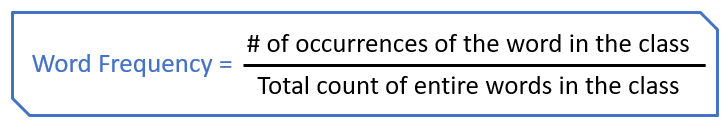

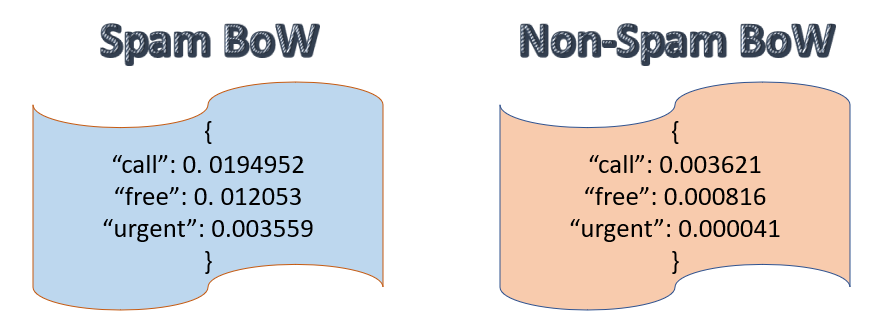

In [21]:
# Word list with high frequencies in spam BoW
newDict = dict(filter(lambda elem: elem[1] > 0.007, train_spam_bow.items()))
newDict

{'': 0.01384628140286875,
 'or': 0.01069563054473095,
 'call': 0.019484288201641654,
 'now': 0.010529806815355277,
 'txt': 0.00837409833347152,
 'and': 0.007130420363153967,
 'from': 0.007296244092529641,
 'have': 0.007793715280656662,
 'to': 0.0387198408092198,
 'mobile': 0.007213332227841804,
 'your': 0.01384628140286875,
 'you': 0.01724566785507006,
 'on': 0.008539922062847193,
 'u': 0.008291186468783683,
 'ur': 0.007959539010032336,
 'free': 0.011690572920984993,
 'is': 0.008788657656910705,
 'the': 0.011856396650360666,
 '2': 0.009369040709725562,
 'for': 0.01069563054473095,
 'a': 0.0213912610894619}

In [23]:
# Word list with high frequencies in non-spam BoW
newDict2 = dict(filter(lambda elem: elem[1] > 0.007, train_non_spam_bow.items()))
newDict2

{'': 0.02431980857690959,
 'i': 0.03219950906578106,
 'it': 0.0080859753707791,
 'me': 0.01095319622929516,
 'and': 0.012252727985313228,
 'of': 0.007425895748674684,
 'my': 0.010416881536335321,
 'in': 0.011468883434064233,
 'to': 0.02281400193898389,
 'that': 0.0070339734730501865,
 'you': 0.027352049340951753,
 'u': 0.013882299552383506,
 'is': 0.010189979166236927,
 'the': 0.01650199055261041,
 'for': 0.007116483425813239,
 'a': 0.01499618391468471}

## Predicting on the Test Dataset

Now that we have BoWs for the 2 classes ready, we will be using them to make predictions on the test dataset. Given a certain text, we will need to calculate the probability that it came from the spam BoW to determine whether or not it is spam.

1. If the probability is high, we will classify it as spam.
2. If the probability is low, we will classify it as non-spam.

Before we get into the code example, we will first need to understand how these probabilities are calculated.

### Step 1. Set our target: Conditional Probability of being SPAM given some text message

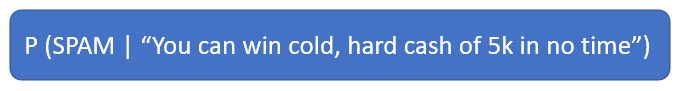

### Step 2. Use Bayes' Theorem: Reverse the conditional probability

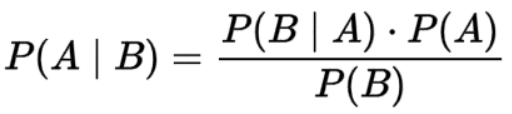

To make our calculations easier, we will reverse the conditional probability using Bayes' Theorem. Based on the fact that original conditional probability is proportional to (reversed conditional probability * prior probability), we can omit the denominator in Bayes' Theorem equation for our purpose.

Note: We are comparing the relative probabilities here, not absolute probabilities.

As a result, the probability of seeing the text message given the message is spam (reversed conditional probability) is multiplied by the probability of the message being spam (prior probability).

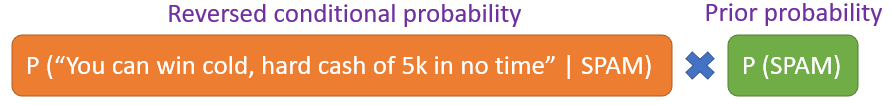

### Step 3. Use Naïve Bayes Assumption: Break up reversed conditional probability

Because the keys of our respective BoWs are individual words, not the whole text message, we will need to further break up the reversed conditional probability into probabilities of seeing respective words given these words came from "spam" BoWs.

Note: Assuming words in the text are completely independent of each other, we can safely apply the Naïve Bayes Assumption to break up the reversed conditional probability.

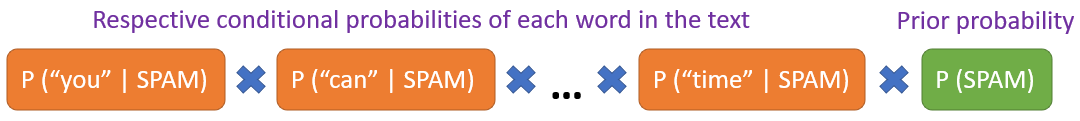

### Step 4. Apply Logarithm: Conquer numerical instability

Thought we were done? Not quite. There is one more thing to consider. Because the score is obtained by multiplying a bunch of small (sometimes tiny) probabilities together, this can lead to numerically unstable outcomes (e.g. close to being 0). Therefore, we will be applying logarithm to the equation:

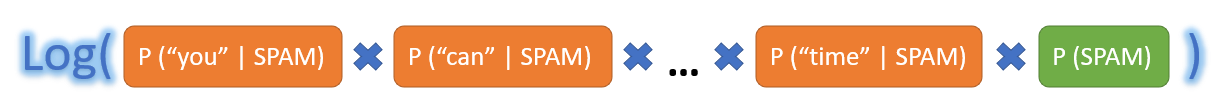

Note: Wait… Why applying logarithm does not make any difference here?

1. maximizing/minimizing some number is the same as maximizing/minimizing log of that number.
2. Because we are comparing two scores after all, taking log of both scores does not change the result.

Putting finishing touches, we will use logarithm product rule to apply log to individual elements inside.

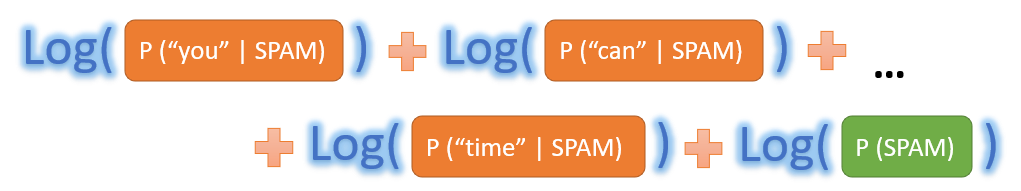

In [30]:
def predict_text(text, verbose=False, return_df=False):
    """
    # Summary: Calculate spam/non-spam scores for the given text, \
               returning the prediction based on the scores.
    # Input: a text message comprised of different words
    # output: classification of the input message (spam or non-spam)
    """
    
    # Create a Python list of valid words that are present in both BoWs
    words_list = text.lower().split()
    valid_words = [word for word in words_list if word in train_spam_bow]
    
    # get the probabilities of each valid word showing up in respective BoWs
    spam_probs = [train_spam_bow[w] for w in valid_words]
    non_spam_probs = [train_non_spam_bow[w] for w in valid_words]
    
    # If verbose, print probabilities of seeing the word in respective classes
    if verbose:
        data_df = pd.DataFrame()
        data_df['word'] = valid_words
        data_df['spam_prob'] = spam_probs
        data_df['non_spam_prob'] = non_spam_probs
        data_df['ratio'] = [sp/nsp if nsp > 0 else np.inf \
                            for sp, nsp in zip(spam_probs, non_spam_probs)]
        print(data_df)
        
    
    # calculate spam score as sum of logs for all probabilities
    # log(P(word_1|SPAM)) + log(P(word_2|SPAM)) + ... \
    #      + log(P(word_n|SPAM)) + log(P(SPAM))
    spam_score = sum([np.log(p) for p in spam_probs]) + np.log(FRAC_SPAM_TEXTS)
    
    #calculate non-spam score as sum of logs for all probabilities
    # log(P(word_1|non-SPAM)) + log(P(word_2|non-SPAM)) + ... \
    #      + log(P(word_n|non-SPAM)) + log(P(non-SPAM))
    non_spam_score = sum([np.log(p) for p in non_spam_probs]) + np.log(1-FRAC_SPAM_TEXTS)
    
    #if verbose, report the two scores
    if verbose:
        print('Spam Score: %s'%spam_score)
        print('Non-Spam Score: %s'%non_spam_score)
   
    if return_df:
        return data_df
    else:
        #if spam score is higher, mark the input text as spam
        return (spam_score >= non_spam_score)

When we feed the example text "urgent call this number to win cash" into the function, we get the following output;

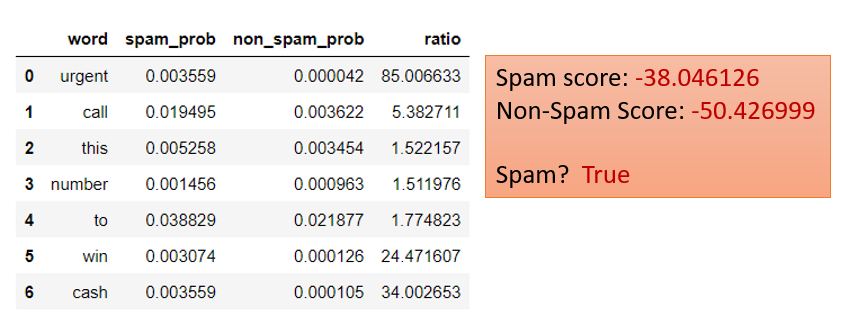

As you might have already noticed from the output, there are 3 words that contributed most to the example text being classified as spam. "urgent", "win", "cash".

In [31]:
predict_text('urgent call this number to win cash', verbose=True)

     word  spam_prob  non_spam_prob       ratio
0  urgent   0.003648       0.000021  176.857309
1    call   0.019484       0.003548    5.491737
2    this   0.004809       0.003383    1.421525
3  number   0.001658       0.001011    1.640606
4      to   0.038720       0.022814    1.697196
5     win   0.003399       0.000124   27.466476
6    cash   0.003151       0.000124   25.456734
Spam Score: -38.04081251651583
Non-Spam Score: -50.92819775250106


True

In [33]:
df_out = predict_text('urgent call this number to win cash', verbose=True, return_df=True)
df_out

     word  spam_prob  non_spam_prob       ratio
0  urgent   0.003648       0.000021  176.857309
1    call   0.019484       0.003548    5.491737
2    this   0.004809       0.003383    1.421525
3  number   0.001658       0.001011    1.640606
4      to   0.038720       0.022814    1.697196
5     win   0.003399       0.000124   27.466476
6    cash   0.003151       0.000124   25.456734
Spam Score: -38.04081251651583
Non-Spam Score: -50.92819775250106


,word,spam_prob,non_spam_prob,ratio
0,urgent,0.003648,0.000021,176.857309
1,call,0.019484,0.003548,5.491737
2,this,0.004809,0.003383,1.421525
3,number,0.001658,0.001011,1.640606
4,to,0.038720,0.022814,1.697196
5,win,0.003399,0.000124,27.466476
6,cash,0.003151,0.000124,25.456734


In [34]:
predict_text('Are you up coming over tonight', verbose=True)

      word  spam_prob  non_spam_prob     ratio
0      are   0.004394       0.006085  0.722145
1      you   0.017246       0.027352  0.630507
2       up   0.001492       0.003857  0.386902
3     over   0.000663       0.000804  0.824510
4  tonight   0.000166       0.000722  0.229685
Spam Score: -34.07199518822238
Non-Spam Score: -28.75471523729296


False

In [35]:
predict_text('we offer unlimited cash limited time only', verbose=True)

        word  spam_prob  non_spam_prob      ratio
0         we   0.002819       0.004043   0.697257
1      offer   0.001410       0.000124  11.388539
2  unlimited   0.000332       0.000083   4.019484
3       cash   0.003151       0.000124  25.456734
4       time   0.001161       0.002847   0.407774
5       only   0.004063       0.001939   2.095263
Spam Score: -40.526186029950466
Non-Spam Score: -45.15204065608626


True

## Applying the function to test dataset

In [37]:
predictions = test_spam_df['text'].apply(lambda t: predict_text(t))

# Precentage of the correct predictions
prediction_accuracy = np.sum((predictions == True) & (test_spam_df['label'] == True)) / np.sum(test_spam_df['label'] == True)
print('Fraction Spam Correctly Detected: %s'%prediction_accuracy)

# Precentage of the incorrect predictions
wrongly_classified_as_spam = np.sum((predictions == True) & (test_spam_df['label'] == False)) / np.sum(test_spam_df['label'] == False)
print('Fraction Spam Incorrectly Detected: %s'%wrongly_classified_as_spam)

Fraction Spam Correctly Detected: 0.8825910931174089
Fraction Spam Incorrectly Detected: 0.018947368421052633


## Final Words on Bag-of-Words

While Bag-of-Words technique is a great starting point for word representation, it has its limitations. Especially, it does not take into account:

1. Meaning of words (No Context)
2. Order of words (No Syntax)

## Reference

The code used for the implementation example of Bag-of-words was based on the code written by ritvikamath: https://github.com/ritvikmath/YouTubeVideoCode/blob/main/Spam%20Filtering.ipynb